# Poromechanical applications

This tutorial show how to set up and run poromechanical verications.

We focus on two concrete cases:

- A non-linear poromechanical model using a manufactured solution.
- Mandel's consolidation problem based on the Biot equations of poroelasticity.

Other verifications can be run in a similiar fashion.

## Non-linear poromechanical model

Let us first import the mixer class `ManuPoroMechNoFrac`.

In [4]:
import porepy as pp
import numpy as np

from porepy.applications.verification_setups.manu_poromech_nofrac import (
    ManufacturedNonlinearPoromechanicsNoFrac2d as ManuSetup,

)

Now, we set the verification setup parameters. For this particular example, we set
`material_constants` containing the values of the fluid and solid physical constants,
a `time_manager` object, and select as `manufactured_solution` a parabolic profile
for both pressure and displacement. In addition, we will use a mesh size of `0.03
[m]` and plot the results of the veritication.

In [5]:
# Set material constants
solid = pp.SolidConstants(
    {
        "biot_coefficient": 0.65,
        "lame_lambda": 1.5,
        "permeability": 0.3,
        "porosity": 0.15,
        "shear_modulus": 2.5,
    }
)
fluid = pp.FluidConstants(
    {
        "compressibility": 0.05,
        "density": 1.2,
        "viscosity": 0.75,
    }
)
material_constants = {"solid": solid, "fluid": fluid}

# Set mesh arguments
mesh_arguments = {"mesh_size_frac": 0.05, "mesh_size_bound": 0.05}

# Create time manager object
time_manager = pp.TimeManager(
    schedule=[0, 1],
    dt_init=0.05,
    constant_dt=True
)

# Finally, create the params dictionary
params = {
    "manufactured_solution": "varela_2021",
    "material_constants": material_constants,
    "mesh_arguments": mesh_arguments,
    "time_manager": time_manager,
    "plot_results": True,
}

We are now in position to run the verification setup. To do this, we create an
instance of the `ManuSetup` class and pass the `params` as a parameter. We then use
the method `run_time_dependent_model` to run the model.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jvmini/Git/porepy/src/porepy/models/solution_strategy.py:452: UserWarning: PyPardiso could not be imported,
                    falling back on scipy.sparse.linalg.spsolve
  warnings.warn(


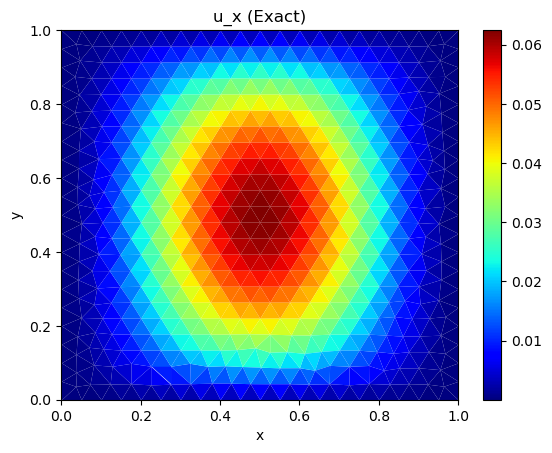

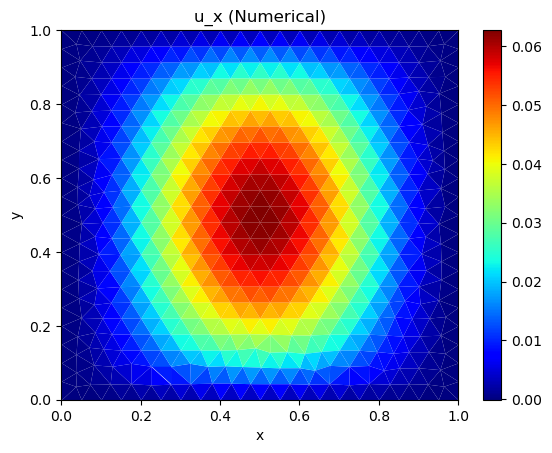

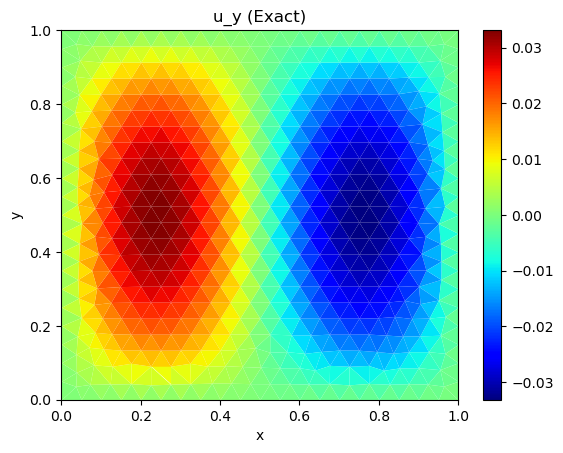

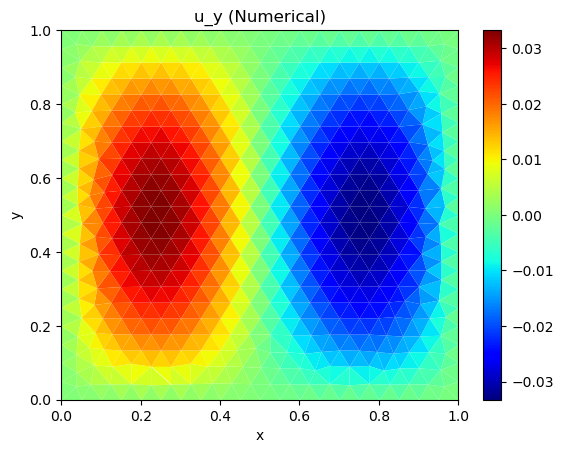

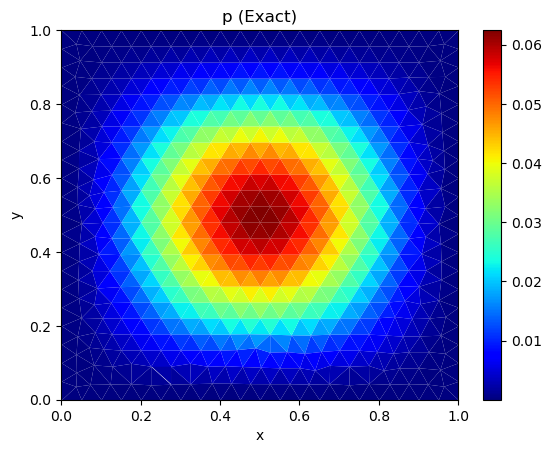

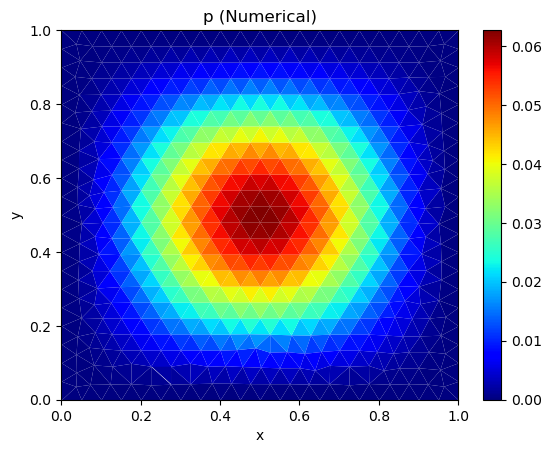

Simulation finished in 27 seconds.


In [6]:
from time import time
tic = time()
setup = ManuSetup(params=params)
pp.run_time_dependent_model(model=setup, params=params)
toc = time()
print(f"Simulation finished in {round(toc - tic)} seconds.")

The plots show the exact and numerical pressure and displacement fields for the final
simulation time. We can see by visual inspection of good level of agreement. We can
also measure this error in the L2-norm.

In [7]:
print(f"Pressure error: {setup.results[-1].error_pressure}.")
print(f"Displacement error: {setup.results[-1].error_displacement}.")

Pressure error: 0.004089881417014428.
Displacement error: 0.004281495323216319.


## Mandel's problem

Let us now set up an example of Mandel's problem. Note that unlike the previous example
that considers a compressible fluid, Mandel's problem is based on the Biot equations,
that assumes only a slightly compressible fluid. Thus, the verification is based from
the derived model class `BiotPoromechanics`
(see `porepy.applications.derived_models.biot`), which implements the necessary
simplifications.

As in the previous example, let us first import the verification setup class:

In [8]:
from porepy.applications.verification_setups.mandel_biot import MandelSetup

Now, it is simply a matter of declaring the model parameters. In this example, we
will use real physical parameters. For the user's convinience, the `mandel_biot.py`
module contains suggested physical constants for the fluid and the solid. Let's
import it them:

In [9]:
from porepy.applications.verification_setups.mandel_biot import (
    mandel_fluid_constants,
    mandel_solid_constants
)

The full list of available